In [1]:
# Parallelität
import multiprocessing

# Kommunkation mit Betriebssystem
import os

# Reguläre Ausdrücke
import re
import string

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Word2Vec von Gensim
import gensim.models.word2vec as w2v

# Dimensionsverminderung
import sklearn.manifold

# Plot von Matplotlib
import matplotlib.pyplot as plt

# DatasetParser
import pandas as pd

# Kommunikation mit Mongo DB
import pymongo

import numpy as np
from scipy import spatial

In [2]:
# Order, wo dieses Jupyter-Notebook befindet
current_path=os.getcwd()

#print(current_path)

In [3]:
db_server = '141.45.146.247'
db_port= 27017

client = pymongo.MongoClient(db_server, db_port)

In [4]:
def getData(file, key):
   return file[key]

In [5]:
gr1_collection = client.gruppe1.articles

artikels_1=gr1_collection.find()
print(artikels_1.count())

909


In [6]:
texte=[]

for artikel in artikels_1:
    text=getData(artikel, 'text')
    texte.append(text)
    
print(len(texte))    

909


In [7]:
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

In [8]:
corpus_raw = u""

In [9]:
for text in texte:
    corpus_raw += text

In [10]:
raw_sentences = tokenizer.tokenize(corpus_raw)
print(len(raw_sentences))

30612


In [11]:
def sentence_to_wordlist(raw):
    text = raw.lower()
    
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)
    
    words = word_tokenize(text)
    
    result = []
    stop_words = set(stopwords.words('german'))
    for word in words:
        if word not in stop_words:
            result.append(word)

    return result

In [12]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [13]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 328,260 tokens


In [14]:
num_features = 300

#
# Minimum word count threshold.
min_word_count = 5 #3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 3 #7

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [15]:
article2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [16]:
%%time
article2vec.build_vocab(sentences)

CPU times: user 371 ms, sys: 9.89 ms, total: 381 ms
Wall time: 380 ms


In [17]:
print("Word2Vec vocabulary length:", len(article2vec.wv.vocab)) # Achtung!

Word2Vec vocabulary length: 10300


In [18]:
%%time

#train model on sentneces
article2vec.train(sentences, total_examples=article2vec.corpus_count, epochs=article2vec.epochs)

CPU times: user 16.1 s, sys: 181 ms, total: 16.2 s
Wall time: 5.58 s


(1210660, 1641300)

In [19]:
%%time

model_path = "trained_big"
if not os.path.exists(current_path+"/"+model_path):
    os.makedirs(current_path+"/"+model_path)

model_name = "article2vec.w2v"
article2vec.save(current_path+"/"+model_path+"/"+model_name)

CPU times: user 192 ms, sys: 95.7 ms, total: 287 ms
Wall time: 295 ms


In [20]:
article2vec = w2v.Word2Vec.load(current_path+"/"+model_path+"/"+model_name)

In [21]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [22]:
%%time
all_word_vectors_matrix = article2vec.wv.vectors #Achtung

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10 µs


In [23]:
%%time
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

CPU times: user 4min 20s, sys: 21.2 s, total: 4min 41s
Wall time: 4min 42s


In [24]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[article2vec.wv.vocab[word].index])
            for word in article2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [25]:
%%time
points.head(10)

CPU times: user 1.93 ms, sys: 367 µs, total: 2.3 ms
Wall time: 2.85 ms


,word,x,y
0,eu,-7.751759,-56.689220
1,vera,-10.982236,59.774460
2,jourova,70.490532,34.085926
3,zunehmenden,-24.826342,54.490986
4,wählern,-4.285128,-19.351233
5,internet,-31.124170,-6.134931
6,gewarnt,2.510535,-23.483768
7,„,-86.400772,-13.489575
8,’,-87.572319,-14.055031
9,black,-47.956238,-36.661034


CPU times: user 83.5 ms, sys: 3.2 ms, total: 86.7 ms
Wall time: 87.3 ms


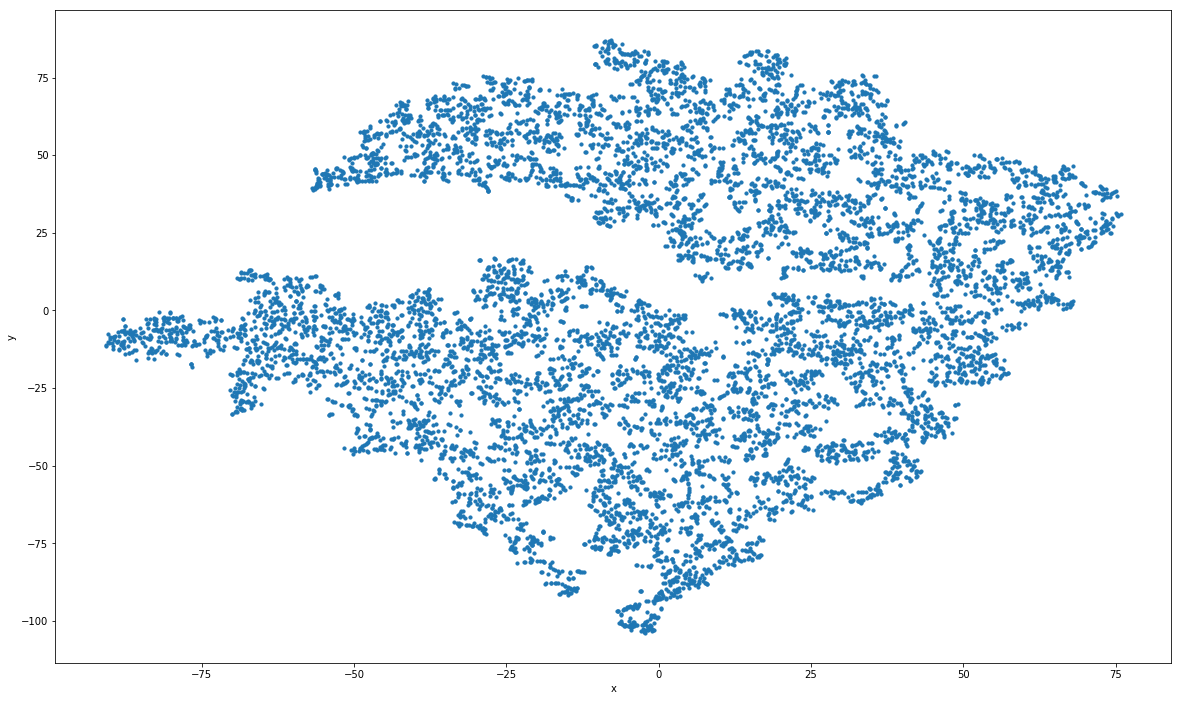

In [26]:
%%time

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [27]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) & (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) & (points.y <= y_bounds[1]) 
    ]
    
    print(slice)
    
    if(slice.empty):
        print("DataFrame is empty. Please choose other x/y")
    else:
        ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

                   word          x          y
6               gewarnt   2.510535 -23.483768
68       traditionellen   3.153004 -29.234129
99              uniform  18.709303 -23.625376
145           ähnliches   8.365101 -30.356043
151        gewerkschaft   3.413838 -25.326387
184        kriminalität  24.695761 -29.122021
240            ersetzen  13.376417 -25.106558
328           geltenden   4.196253 -36.224174
496              gelder  12.883231 -26.349625
622               heiße   3.393140 -28.354303
673             scharfe   5.429485 -20.086273
678             gebiete  17.942320 -20.623398
738    körperverletzung  15.406327 -28.362822
853             gefühle  12.407612 -21.185177
878              tieren   8.134622 -34.937744
906              dienen  14.855852 -24.992821
912           einstigen  11.862438 -32.505871
920           gewachsen   2.852190 -36.725033
976          gestellten  23.849319 -37.784637
1025          gesammelt  17.959549 -39.828407
1040           springen  19.175894

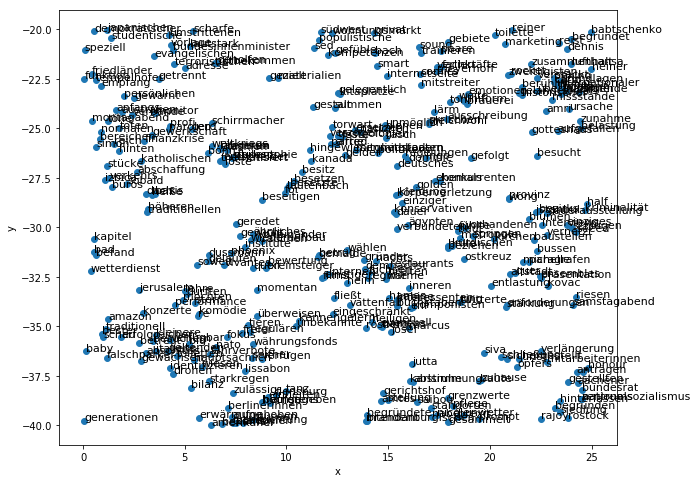

In [28]:
plot_region(x_bounds=(0, 25), y_bounds=(-40, -20))

In [29]:
def getMostSimilar(model, word):
    try:
        word=word.lower()
        return model.wv.most_similar(word)
    except KeyError:
        return 'None'

In [35]:
getMostSimilar(article2vec, "sport")

[('beitrag', 0.999421238899231),
 ('christina', 0.999366044998169),
 ('boateng', 0.9993614554405212),
 ('burning', 0.9993428587913513),
 ('nötigen', 0.9993200302124023),
 ('regelmäßig', 0.9993194937705994),
 ('fake', 0.9992881417274475),
 ('kommentierte', 0.9992818832397461),
 ('nah', 0.9992655515670776),
 ('erbe', 0.9992563724517822)]

In [31]:
tt1='Moderne Polizeiarbeit verlangt eine Menge Toleranz, und zwar eher von Polizisten als von Bürgern. Das ist eine angenehme Entwicklung: Niemandem muss der Schweiß ausbrechen, wenn er nach seinem Personalausweis gefragt wird. Dass Polizisten hierzulande mal autoritär und herrisch aufgetreten sind, wissen bloß noch ältere Leute. Jüngere wundern sich, wenn sie es in Spanien oder den Vereinigten Staaten mit Polizisten zu tun bekommen, welche Ruppigkeit einer Uniform innenwohnen kann.Gut so? Ja, für die, die sich an Regeln und Umgangsformen halten. Weniger für die, die Regeln durchsetzen sollen, wenn sie nicht beachtet werden. Nimmt man die Kriminalitätsstatistik als Hinweis darauf, in welchem Umfang Regeln gebrochen und Umgangsformen zerstört werden, ergibt sich hierzulande ein widersprüchliches Bild: Einerseits werden weniger Delikte angezeigt – und gerade dann, wenn Polizeibehörden massiv und mit verstärktem Personalaufwand zum Beispiel Einbrecherbanden verfolgen, lohnt sich das. Andererseits ist der mehr oder minder formierte Widerstand gegen die Staatsgewalt längst zum Dauerphänomen geworden. Der Aufstand im Flüchtlingsheim von Ellwangen hat bloß überdeutlich gezeigt, womit Polizisten heute zu rechnen haben: mit robustem Widerstand vieler junger Männer, die nicht interessiert, dass das polizeiliche Vorgehen vom Recht gedeckt war. Ein schräges Beispiel – geht es doch um Flüchtlinge in Existenznot? Tatsache ist, dass diese jungen Männer zeigten: Eure Regeln sind nicht unsere.Ähnliches erfahren Polizisten in vielen größeren Städten hierzulande ständig. Der Gewerkschaft der Polizei zufolge erleben im Durchschnitt 133 Beamtinnen und Beamte täglich Widerstand. Das ist nicht wenig und summiert sich im Jahr zu 74 000 Delikten, deren Opfer Polizisten sind.Die Broken-Windows-Theorie hat eben nicht nur eine materielle, sondern auch eine soziale Komponente. Mitte der neunziger Jahre hatte der New Yorker Polizeichef William Bratton auf der Grundlage dieser Theorie eine Null-Toleranz-Strategie entwickelt: Kaputte Fenster, herumliegender Müll, ausgeweidete Autowracks – wo Unordnung herrscht, kommen Vandalismus und handfeste Kriminalität hinzu. Bratton leitete daraus die Anweisung an seine Polizisten ab, Delinquenz jeder Art konsequent zu verfolgen. Keine Nachsicht, mit Dealern so wenig wie mit Obdachlosen. New York ist zu einer anderen Stadt geworden.Die soziale – oder eher: verhaltensmäßige – Komponente der Broken-Windows-Theorie kann man in Berlin beobachten. Wenn Verstöße gegen verbindliche Regeln geahndet werden, ändert sich die Lage zugunsten derer, die sich an die Regeln halten. Im Tiergarten zum Beispiel lässt der Bürgermeister von Mitte, Stephan von Dassel, Obdachlosencamps regelmäßig räumen. Zigmal sind Leute vom Ordnungsamt und Polizisten eingeschritten – was zeigt, wie weit der Tiergarten schon okkupiert war. In Neukölln hat die frühere Bürgermeisterin Franziska Giffey Polizei, Ordnungs- und Gewerbeamt in eine Art Dauereinsatz gegen die Art von Bezirksbewohnern geführt, die sich nicht an Regeln hielten. Die hatten sich an den Gedanken gewöhnt, dass von der Polizei bis zum Ordnungsamt alle über zu wenig Personal klagten und freitagabends ohnehin ihre Ruhe haben wollten. Das ist jetzt anders; auch Mitglieder arabischer Clans haben gemerkt, dass sie sich nicht mehr jede Freiheit nehmen können. Und die erfreuliche Aufmerksamkeit von Berliner Polizisten für sogenannte Profilierungsfahrer hat nun schon häufiger dazu geführt, dass nicht bloß Führerscheine eingezogen wurden, sondern auch gleich die Autos.Ordnungspolitik setzt mehr Personal voraus, als da ist. Sie setzt Eindeutigkeit voraus, die etwa im Umgang mit Dealern nicht gegeben ist. Ordnungspolitik kann – Stichwort Obdachlose – Sozialpolitik nicht ersetzen. Aber eine gesellschaftliche Ordnung behauptet und erhält sich nicht von allein.Offenbar geht es nicht anders: Menschen beachten Regeln und Umgangsformen, weil sie den simplen Satz „Wie du mir, so ich dir“ verstanden haben. Oder sie müssen daran erinnert werden – so lange, bis sie begreifen. Das Fatale an der Gewalt gegen Polizisten und auch gegen Feuerwehrleute oder Rettungssanitäter liegt – über den einzelnen Angriff hinaus – in der zerstörerischen Wirkung auf Gesellschaft. Es liegt in der Behauptung des „Ich mache, was ich will – alle anderen interessieren mich nicht“. Diese Überzeugung hat sich ohnehin mehr als breitgemacht.'
tt2='Die ARD will genau abwägen, ob ihr Dopingexperte Hajo Seppelt zur Fußball-WM nach Russland reisen wird. Vor dem Hintergrund der neuen Rahmenbedingungen für das Visum des Journalisten werde in Ruhe geprüft und nach „inhaltlicher Einschätzung“ entschieden, ob und wann Seppelt nach Russland reisen werde, sagte ARD-Sportkoordinator Axel Balkausky am Mittwoch.Tags zuvor hatten die russischen Behörden, die die Ausstellung des Visums zunächst verweigert hatten, überraschend doch die Einreise erlaubt. „Wir bedanken uns bei der Bundesregierung und bei der Fifa für die Kooperation und Unterstützung in den letzten Tagen“, sagte Balkausky.Seppelt selbst reagierte auf die neue Einreiseerlaubnis sehr zurückhaltend. Der Journalist erklärte am Dienstagabend ebenfalls, seine Teilnahme gemeinsam mit seinem Sender genau prüfen zu wollen. „Die angekündigte Vorladung vor eine Art Untersuchungsgericht jedenfalls hört sich nicht wirklich einladend an“, sagte Seppelt laut „Spiegel Online“ nach einem Telefonat mit der russischen Botschaft. Die Diplomaten hatten demnach bestätigt, dass Seppelt in Russland von einem Untersuchungskomitee verhört werden soll.Aus russischer Sicht beruhen Seppelts Filme über Staatsdoping in Russland auf falschen Informationen. Seppelt wurde laut „Spiegel Online“ auch mitgeteilt, sein Visum werde nur wegen der geltenden Regularien des Weltfußballverbandes Fifa ausgestellt. Diese regelt die Visa-Vergabe an ausländische Journalisten. Er gelte nach wie vor als „unerwünschte Person“. Die russische Justiz hatte angekündigt, Seppelt zu vernehmen, falls dieser zur Fußball-WM nach Russland kommen sollte. Hintergrund seien die laufenden russischen Ermittlungen gegen den Doping-Kronzeugen Grigori Rodschenkow, sagte die Sprecherin des Staatlichen Ermittlungskomitees. Russland habe Deutschland um Rechtshilfe ersucht, um Seppelt zu dessen Enthüllungen über angebliches Doping befragen zu können. Die deutsche Seite habe immer darauf verwiesen, dass der Journalist von seinem Recht auf Zeugnisverweigerung Gebrauch mache. „Sollte Seppelt jetzt das Gebiet der Russischen Föderation betreten, wird das Staatliche Ermittlungskomitee erneut Mittel ergreifen, um ihn zu befragen“, sagte eine Sprecherin.Seppelt recherchiert seit vielen Jahren zu Doping im deutschen und weltweiten Spitzensport. Sein Film "Geheimsache Doping: Wie Russland seine Sieger macht" hatte die Aufdeckung des russischen Dopingskandals bei den Olympischen Winterspielen 2014 in Sotschi zur Folge. Dem Journalisten wurde das bereits ausgestellte Visum für die Einreise zur Fußball-WM entzogen. Am Freitag hatte die ARD mitgeteilt, dass das für Seppelt beantragte Visum für ungültig erklärt wurde. Der Investigativjournalist stehe auf einer Liste der in Russland „unerwünschten Personen“. Die Bundesregierung hatte darauf Moskau am Montag dazu aufgefordert, die Entscheidung zurückzunehmen. Berlin halte "die Maßnahme der russischen Behörden, Herrn Seppelt das Visum für ungültig zu erklären, für falsch", sagte Regierungssprecher Steffen Seibert. Die Bundesregierung hoffe, dass Russland "diese aus unserer Sicht falsche Entscheidung revidiert", und appelliere an Moskau, Seppelt die Einreise zur Berichterstattung über die Fußball-WM zu ermöglichen. Diese Aufforderung aus Berlin wurde in Moskau nun offenbar erhört. Die Fußball-WM 2018 findet vom 14. Juni bis 15. Juli in elf russischen Städten statt. (Tsp, epd)'

tt1=tt1.lower()
tt2=tt2.lower()

In [32]:
def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [33]:
index2word_set = set(article2vec.wv.index2word)

In [34]:
s1_afv = avg_feature_vector(tt1, model=article2vec, num_features=300, index2word_set=index2word_set)
s2_afv = avg_feature_vector(tt2, model=article2vec, num_features=300, index2word_set=index2word_set)
sim = 1 - spatial.distance.cosine(s1_afv, s2_afv)
print(sim)

0.9900032877922058


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
